# 18기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

라이브러리

In [101]:

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 0. 데이터 불러오기

In [1]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


### 1. Preprocssing / EDA

결측치 확인 및 데이터 타입 확인
- Product_Category_2 와 Product_Category_3에 다수 결측치가 존재

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


Product_Category_3 의 경우 전체 데이터 4998개 중에서 3454개가 결측 : 비율 69.1%
- 해당 열은 제거하기

In [9]:
df[df["Product_Category_3"].isnull()].shape[0] / len(df) * 100 

69.10764305722289

Product_Category_2 의 경우 전체 데이터 4998개 중에서 1533개가 결측 : 비율 30.6%

In [22]:
df[df["Product_Category_2"].isnull()].shape[0] / len(df) * 100 

30.672268907563026

In [23]:
preprocess_df = df.copy()

In [24]:
preprocess_df.drop(["Product_Category_3"],axis=1,inplace=True)

NaN은 없지만 음수와 같은 logical missing value 확인하기
- logical missing value가 존재하지 않음
- 거의 모든 데이터가 categorical
- occupation(직업)도 직업코드로 이루어져있음

In [18]:
preprocess_df.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,7696


In [17]:
for col in preprocess_df.columns:
    print(col,"---------------")
    print(preprocess_df[col].value_counts())

User_ID ---------------
1002063    12
1005795    12
1001980    11
1004344    11
1006036    10
           ..
1004980     1
1004385     1
1004138     1
1002648     1
1000837     1
Name: User_ID, Length: 2656, dtype: int64
Product_ID ---------------
P00265242    21
P00220442    16
P00114942    15
P00010742    15
P00148642    15
             ..
P00072342     1
P00037842     1
P00207042     1
P00129742     1
P00358242     1
Name: Product_ID, Length: 1797, dtype: int64
Gender ---------------
M    3765
F    1233
Name: Gender, dtype: int64
Age ---------------
26-35    1996
36-45    1000
18-25     906
46-50     414
51-55     350
55+       195
0-17      137
Name: Age, dtype: int64
Occupation ---------------
4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18
Name: Occupation, dtype: int64
City_Category ---------------
B    2102
C    1555
A 

User_ID와 Product_ID 값의 종류가 매우 많음
- Product_ID는 제품 ID에 관한 열로 Categorical
- 각각 2656개 1797개의 종류를 가지고 있음
- 거의 대부분의 Product_ID는 코드 42로 끝난다
- Product_ID의 앞의 4자리는 5개의 그룹으로 나뉜다
- Product_ID의 중간 3자리는 935개의 그룹으로 분류된다

In [40]:
test = preprocess_df.copy()

In [41]:
test["Product_ID_last"] = test["Product_ID"].apply(lambda x : x[-2:])
test["Product_ID_first"] = test["Product_ID"].apply(lambda x : x[:4])
test["Product_ID_middle"] = test["Product_ID"].apply(lambda x : x[4:-2])

In [42]:
test["Product_ID_last"].value_counts()

42    4947
44      13
53      11
36      11
93       9
45       7
Name: Product_ID_last, dtype: int64

In [43]:
test["Product_ID_first"].value_counts()

P001    1687
P002    1282
P000    1229
P003     718
P009      82
Name: Product_ID_first, dtype: int64

In [45]:
test["Product_ID_middle"].value_counts()

652    28
107    26
295    23
594    23
108    21
       ..
41      1
857     1
658     1
787     1
671     1
Name: Product_ID_middle, Length: 935, dtype: int64

##### Product_ID_first와 Product_ID_last를 특성으로 가져간다
- 기존의 Product_ID 열은 사용하지 않음

In [46]:
preprocess_df["Product_ID_last"] = preprocess_df["Product_ID"].apply(lambda x : x[-2:])
preprocess_df["Product_ID_first"] = preprocess_df["Product_ID"].apply(lambda x : x[:4])

In [49]:
preprocess_df.drop(["Product_ID","User_ID"],axis=1,inplace=True)

In [50]:
preprocess_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Product_ID_last,Product_ID_first
0,F,0-17,10,A,3,0,5,17.0,2010,42,P000
1,F,0-17,10,A,1,0,7,NaN,4483,42,P003
2,F,0-17,10,A,1,0,1,4.0,7696,42,P000
3,F,0-17,10,A,3,0,2,4.0,16429,42,P001
4,F,0-17,10,A,3,0,3,5.0,5780,42,P001


Product_Category_2의 결측을 해결해야 한다
- 제품 카테고리로 Product ID와 연관성이 높을 것으로 판단
- Product_ID_first와 상관관계 파악해서 결측치 채우기
- 결측치를 채우기 모호한 상황이라 판단해 Product_Category_2의 결측을 채우지 않음

In [69]:
value_count = preprocess_df[["Product_ID_first","Product_Category_2"]].value_counts().reset_index()
value_count.columns = ["Product_ID_first","Product_Category_2","cnt"]

In [70]:
value_count[value_count["Product_ID_first"] == "P001"]

,Product_ID_first,Product_Category_2,cnt
0,P001,2.0,201
2,P001,8.0,187
4,P001,14.0,155
7,P001,16.0,126
9,P001,15.0,115
13,P001,5.0,96
14,P001,4.0,94
20,P001,17.0,66
23,P001,11.0,51
24,P001,6.0,50


In [74]:
preprocess_df.drop(["Product_Category_2"],axis=1,inplace=True)

In [75]:
preprocess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Gender                      4998 non-null   object
 1   Age                         4998 non-null   object
 2   Occupation                  4998 non-null   int64 
 3   City_Category               4998 non-null   object
 4   Stay_In_Current_City_Years  4998 non-null   object
 5   Marital_Status              4998 non-null   int64 
 6   Product_Category_1          4998 non-null   int64 
 7   Purchase                    4998 non-null   int64 
 8   Product_ID_last             4998 non-null   object
 9   Product_ID_first            4998 non-null   object
dtypes: int64(4), object(6)
memory usage: 429.5+ KB


Marital_Status 와 Target인 Purchase를 제외한 데이터 모두 One-hot-Encoding 진행하기

In [76]:
preprocess_df["Marital_Status"].value_counts()

0    2892
1    2106
Name: Marital_Status, dtype: int64

In [77]:
# One-Hot-Encoding (1)

categorical_1 = ['Gender', 'Age', 'Occupation', 'City_Category', 
                 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_ID_last',"Product_ID_first"]

encoder_df = pd.get_dummies(preprocess_df,columns = categorical_1)

In [207]:
encoder_df.shape

(4998, 71)

최종데이터 프레임 확인

In [79]:
encoder_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Marital_Status                 4998 non-null   int64
 1   Purchase                       4998 non-null   int64
 2   Gender_F                       4998 non-null   uint8
 3   Gender_M                       4998 non-null   uint8
 4   Age_0-17                       4998 non-null   uint8
 5   Age_18-25                      4998 non-null   uint8
 6   Age_26-35                      4998 non-null   uint8
 7   Age_36-45                      4998 non-null   uint8
 8   Age_46-50                      4998 non-null   uint8
 9   Age_51-55                      4998 non-null   uint8
 10  Age_55+                        4998 non-null   uint8
 11  Occupation_0                   4998 non-null   uint8
 12  Occupation_1                   4998 non-null   uint8
 13  Occupation_2      

Target 데이터 분포 확인하기
- train_test_split으로 데이터를 나누는 과정에서 Taregt가 고르게 분포해야할 것 같다는 가정

<AxesSubplot:>

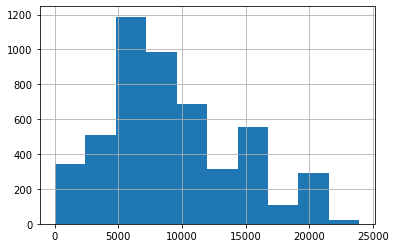

In [82]:
encoder_df["Purchase"].hist()

설명변수와 Target 데이터 분리하기
- y_train, y_test 둘다 원래 분포롸 유사하게 추출된 것을 볼 수 있음

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
X = encoder_df.drop(["Purchase"],axis=1)
y = encoder_df["Purchase"]

x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.2)

<AxesSubplot:>

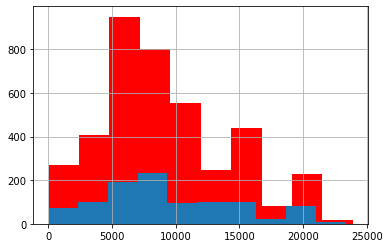

In [92]:
y_train.hist(color="red")
y_test.hist()

In [93]:
x_train.shape[0]

3998

In [94]:
x_test.shape[0]

1000

### KNN 모델링
- 여러가지 조건들을 변경하면서 모델링 진행하기

조건1
- Euclidean Distance를 이용(default)
- n_neighbors를 조정 : 인근 데이터를 몇개까지 탐색할 것인지 일반적으로 1 ~ 20
- weighted KNN이 아닌 가중치가 없는 KNN
- 정확도 기반으로 확인하기

In [99]:
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric, NearestNeighbors

k_range = range(1, 25)
train_accuracy = []
test_accuracy = []

for k in tqdm(k_range): # 1부터 25까지 순차적으로 확인
    reg = KNeighborsRegressor(n_neighbors = k)     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    reg.fit(x_train, y_train)
    train_accuracy.append(reg.score(x_train, y_train))     # k_range에 따른 Score
    test_accuracy.append(reg.score(x_test, y_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.15it/s]


시각화 하기
- n_neighbors 파라미터 수치가 높아짐에 따라 train accuracy는 감소, test accuracy는 증가하는 경향

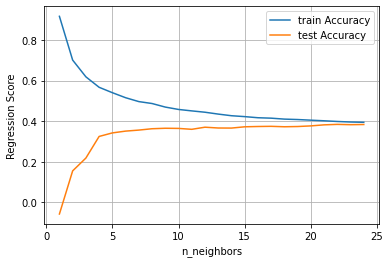

In [102]:
plt.plot(k_range, train_accuracy, label = "train Accuracy")
plt.plot(k_range, test_accuracy, label = "test Accuracy")
plt.xlabel("n_neighbors")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

train accuracy와 test accuracy를 통해 최적의 k 찾기
- train accuracy의 상위 10개 index
- test accuracy의 상위 10개 index 추출해서 교집합을 한다면 확인가능

In [119]:
accuracy_df = pd.DataFrame(train_accuracy,columns=["train_accuracy"])
accuracy_df["k"] = k_range
accuracy_df["test_accuracy"] = test_accuracy
accuracy_df.head()

,train_accuracy,k,test_accuracy
0,0.917291,1,-0.056958
1,0.701695,2,0.155598
2,0.619165,3,0.218829
3,0.567569,4,0.325322
4,0.540989,5,0.342766


In [153]:
train_rank_15 = accuracy_df.sort_values(["train_accuracy"],ascending=False).iloc[:15,1]

test_rank_15 = accuracy_df.sort_values(["test_accuracy"],ascending=False).iloc[:15,1]

In [154]:
train_rank_15.values
# 상위 15개 k값 추출

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [155]:
test_rank_15.values
# 상위 15개 k값 추출

array([22, 24, 23, 21, 20, 17, 16, 19, 18, 15, 12, 13, 14,  9, 10],
      dtype=int64)

In [157]:
import numpy as np
np.intersect1d(train_rank_15.values,test_rank_15.values)

array([ 9, 10, 12, 13, 14, 15], dtype=int64)

k가 12, 13, 14, 15 일때 최고 성능

In [162]:
accuracy_df[(accuracy_df["k"] == 12) | (accuracy_df["k"] == 13) | (accuracy_df["k"] == 14) | (accuracy_df["k"] == 15)]

,train_accuracy,k,test_accuracy
11,0.444678,12,0.370890
12,0.435504,13,0.366932
13,0.427466,14,0.366587
14,0.423048,15,0.372856


#### Distance Measure 변경하기
- Euclidean Distance 대신 다른 Distance Measure 이용해보기
- Manhattan Distance

#### Manhattan
- 뚜렷한 성능의 변화가 보이지는 않음
- Distance Measure가 아닌 데이터 변화시키기

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:30<00:00,  1.28s/it]


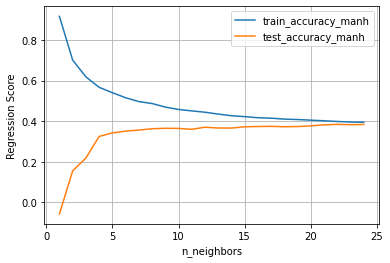

In [160]:
k_range = range(1, 25)
train_accuracy_manh = []
test_accuracy_manh = []

for k in tqdm(k_range): # 1부터 25까지 순차적으로 확인
    reg_manh = KNeighborsRegressor(n_neighbors = k, metric ="manhattan",p=1)
    reg_manh.fit(x_train, y_train)
    
    train_accuracy_manh.append(reg_manh.score(x_train, y_train))     # k_range에 따른 Score
    test_accuracy_manh.append(reg_manh.score(x_test, y_test))
    
    
plt.plot(k_range, train_accuracy_manh, label = "train_accuracy_manh")
plt.plot(k_range, test_accuracy_manh, label = "test_accuracy_manh")
plt.xlabel("n_neighbors")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

#### Accuracy가 낮은 이유
- 모든 데이터가 Categorical이기에 One-Hot-Encoding을 하게 되면 희소행렬이 커지게 되고
- Feauture 수가 많아지고 데이터 간의 거리가 멀어져 모델의 설명력이 감소하게 되는 상태
- 차원축소를 통해 적절하게 희소행렬을 해소해보자

PCA를 통한 차원축소
- 주성분 설명력 합이 90% 이상이 되는 지점 찾기
- https://jimmy-ai.tistory.com/128

In [172]:
from sklearn.decomposition import PCA
n_range = range(1,70)
variance_lst = []


for n in tqdm(n_range):
    pca = PCA(n_components=n) # 주성분을 몇개로 할지 결정
    printcipalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ["col "+str(i) for i in range(n)])
    
    variance_lst.append(sum(pca.explained_variance_ratio_))

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 31.26it/s]


In [169]:
pca.explained_variance_ratio_

array([0.07472087, 0.07038886, 0.0636904 , 0.05967184, 0.05891352,
       0.05253124, 0.0500108 , 0.0476266 , 0.04458646, 0.04071437])

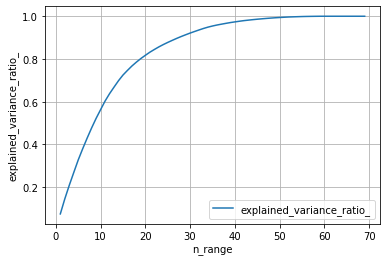

In [173]:
plt.plot(n_range, variance_lst, label = "explained_variance_ratio_")
plt.xlabel("n_range")
plt.ylabel("explained_variance_ratio_")
plt.grid()
plt.legend()
plt.show()

27개의 주성분으로 PCA 할 때부터 총 설명력이 0.9 넘게 된다

In [183]:
pca_series = (pd.Series(variance_lst) > 0.9).reset_index()
pca_series.columns = ["index","over_0.9"]

pca_series[pca_series["over_0.9"]].head(3)

,index,over_0.9
27,27,True
28,28,True
29,29,True


In [185]:
pca = PCA(n_components=27) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ["col "+str(i) for i in range(27)])

PCA 이후 데이터 재분배
- PCA한 데이터를 기반으로 KNN 사용 시 오히려 성능 감소

In [193]:
pca_x_train, pca_x_test,pca_y_train, pca_y_test = train_test_split(principalDf,y,random_state=0,test_size=0.2)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.94it/s]


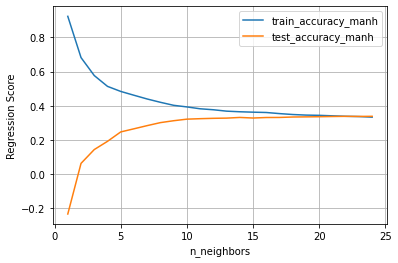

In [194]:
k_range = range(1, 25)
train_accuracy_manh_pca = []
test_accuracy_manh_pca = []

for k in tqdm(k_range): # 1부터 25까지 순차적으로 확인
    reg_manh = KNeighborsRegressor(n_neighbors = k, metric ="manhattan",p=1)
    reg_manh.fit(pca_x_train, pca_y_train)
    
    train_accuracy_manh_pca.append(reg_manh.score(pca_x_train, pca_y_train))     # k_range에 따른 Score
    test_accuracy_manh_pca.append(reg_manh.score(pca_x_test, pca_y_test))
    
    
plt.plot(k_range, train_accuracy_manh_pca, label = "train_accuracy_manh")
plt.plot(k_range, test_accuracy_manh_pca, label = "test_accuracy_manh")
plt.xlabel("n_neighbors")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

### 참고
- 차원 축소를 해결하기 위한 방법
- 우수코드를 참고하여 시도해본 방법
- Occupation을 Purchase를 기준으로 그룹화하고 평균을 내어 Encoding 하는 방식

In [198]:
len(preprocess_df["Occupation"].value_counts())

21

In [196]:
grouped = preprocess_df.groupby(['Occupation']).mean().sort_values(by = ['Purchase'])
grouped

,Marital_Status,Product_Category_1,Purchase
Occupation,,,
19,0.150685,5.123288,8170.465753
6,0.489247,6.069892,8402.354839
0,0.445804,5.412587,8732.351399
10,0.073770,4.975410,8897.926230
20,0.477193,5.705263,8900.733333
11,0.463158,5.536842,8925.147368
13,0.446154,5.692308,8964.907692
4,0.260623,5.184136,9066.113314
16,0.483607,5.364754,9102.409836


In [200]:
occupation_Low = list(grouped.index[:7])
occupation_Medium = list(grouped.index[7:14])
occupation_High = (grouped.index[14:])

print("평균 Purchase가 Low인 Occupation : ", occupation_Low)
print("평균 Purchase가 Medium인 Occupation : ", occupation_Medium)
print("평균 Purchase가 High인 Occupation : ", occupation_High)

평균 Purchase가 Low인 Occupation :  [19, 6, 0, 10, 20, 11, 13]
평균 Purchase가 Medium인 Occupation :  [4, 16, 2, 1, 3, 7, 18]
평균 Purchase가 High인 Occupation :  Int64Index([5, 14, 17, 9, 15, 12, 8], dtype='int64', name='Occupation')


In [202]:
def encode(x):
    if x in occupation_Low:
        return "occupation_Low"
    
    if x in occupation_Medium:
        return "occupation_Medium"
    
    if x in occupation_High:
        return "occupation_High"

In [203]:
preprocess_df["Occupation"] = preprocess_df["Occupation"].apply(lambda x : encode(x))

Occupation Column이 21개에서 3개로 축소

In [205]:
# One-Hot-Encoding (1)

categorical_1 = ['Gender', 'Age', 'Occupation', 'City_Category', 
                 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_ID_last',"Product_ID_first"]

encoder_df_pca = pd.get_dummies(preprocess_df,columns = categorical_1)

In [208]:
encoder_df_pca.shape
# 71개에서 53개로 컬럼 감소

(4998, 53)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.33it/s]


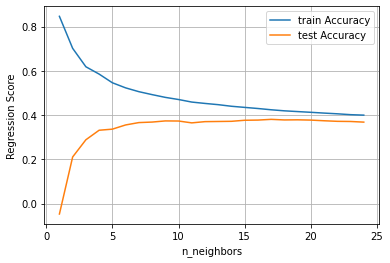

In [209]:
X = encoder_df_pca.drop(["Purchase"],axis=1)
y = encoder_df_pca["Purchase"]

x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.2)

k_range = range(1, 25)
train_accuracy = []
test_accuracy = []

for k in tqdm(k_range): # 1부터 25까지 순차적으로 확인
    reg = KNeighborsRegressor(n_neighbors = k)     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    reg.fit(x_train, y_train)
    train_accuracy.append(reg.score(x_train, y_train))     # k_range에 따른 Score
    test_accuracy.append(reg.score(x_test, y_test))

plt.plot(k_range, train_accuracy, label = "train Accuracy")
plt.plot(k_range, test_accuracy, label = "test Accuracy")
plt.xlabel("n_neighbors")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

In [210]:
accuracy_df = pd.DataFrame(train_accuracy,columns=["train_accuracy"])
accuracy_df["k"] = k_range
accuracy_df["test_accuracy"] = test_accuracy
accuracy_df.head()

,train_accuracy,k,test_accuracy
0,0.847030,1,-0.046975
1,0.702338,2,0.211023
2,0.618961,3,0.288804
3,0.585845,4,0.331894
4,0.546631,5,0.336784


미세하게나마 성능 증가
- 원핫인코딩 때문에 발생한 희소행렬이 거리 기반 알고리즘에 악영향을 주는 차원의 저주가 나타남

In [212]:
train_rank_15 = accuracy_df.sort_values(["train_accuracy"],ascending=False).iloc[:15,1]

test_rank_15 = accuracy_df.sort_values(["test_accuracy"],ascending=False).iloc[:15,1]

np.intersect1d(train_rank_15.values,test_rank_15.values)

accuracy_df[(accuracy_df["k"] == 12) | (accuracy_df["k"] == 13) | (accuracy_df["k"] == 14) | (accuracy_df["k"] == 15)]

,train_accuracy,k,test_accuracy
11,0.453118,12,0.370780
12,0.447534,13,0.371513
13,0.440321,14,0.372274
14,0.435215,15,0.377016
